<a href="https://colab.research.google.com/github/Jesus-Vazquez-A/Insurence/blob/main/Selection_of_model_ideal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings # ignore warnings
import pandas as pd # data manipulation
import numpy as np # linear algebra
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("/content/insurence_clear.csv")
df=df.drop(["Unnamed: 0"],axis="columns")

In [4]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,18,male,33.77,1,no,southeast,1725.5523
1,28,male,33.00,3,no,southeast,4449.4620
2,25,male,26.22,0,no,northeast,2721.3208
3,23,male,34.40,0,no,southwest,1826.8430
4,19,male,24.60,1,no,southwest,1837.2370


In [5]:
def dataset():
    return df.drop(["charges"],axis="columns"),df.charges.values

X,y=dataset()


# **Split data**

In [6]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,
                                               y,
                                               test_size=0.33,
                                               random_state=42)

### **Data preprocessing**

* **MinMaxScaler**  It consists of adjusting the data on a scale from 0 to 1. With the aim that the variables are comparable to each other. 

* **OneHotEncoding** It is used for qualitative variables. For example the geographical location or the color of a car.
It consists of creating several fictitious variables according to the number of categorical variables. Where a 1 is indicated if said observation belongs to the class. It's a similar thing with truth tables if you're familiar with programming.


* **PolynomialFeatures** It consists of raising to a certain power. To break the linearity of the data. Since sometimes a linear regression is not enough to solve the problem.

In [7]:
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,PolynomialFeatures 

In [9]:
poly=PolynomialFeatures(degree=2) # degree polynomial
rescale=MinMaxScaler()
def poly_transform(x):
    
    x=pd.get_dummies(x,drop_first=True,columns=["sex","smoker","region"]) # dummy variables
    x[["age","bmi","children"]]=rescale.fit_transform(x[["age","bmi","children"]]) # reescale
    
    return poly.fit_transform(x) # polynomial transform

In [10]:
X_train_poly=poly_transform(X_train)
X_test_poly=poly_transform(X_test)

## **Creation of the polynomial model**

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
poly.fit(X_train_poly,Y_train) # we give the training data

PolynomialFeatures()

In [13]:
lm=LinearRegression()

In [14]:
lm.fit(X_train_poly,Y_train) #  we give the training data

LinearRegression()

In [15]:
lm.score(X_train_poly,Y_train) # evaluate with training data

0.9634029455648855

In [16]:
lm.score(X_test_poly,Y_test) # evaluate with testing data

0.9534487395422595

## **Data transform**

In [17]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

In [18]:
tf_colummns=make_column_transformer((MinMaxScaler(),["age","bmi","children"]), # Reescale
                                   (OneHotEncoder(drop="if_binary"),["region","sex","smoker"])) # OneHotEncoding

## *Mean square error*
Measures the average error between the original and predicted values.

In [19]:
from sklearn.metrics import mean_squared_error

# **Gradient Boosting**

It is an algorithm that uses such complex algorithms. That is perfected according to the learning rate assigned by the user. In such a way that each tree will become better than the previous one. And the predicted value is going to average the predictions of the weakest algorithms.

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

In [21]:
def evaluate(max_depth,lr):
    
    estimator_list=[]
    mse_train_list=[]
    mse_test_list=[]

    estimators=np.arange(100,1000,step=2)
    for estimator in estimators:
      
        model=GradientBoostingRegressor(max_depth=max_depth,n_estimators=estimator,learning_rate=lr,random_state=42)
        model=Pipeline([("transform",tf_colummns),("model",model)])
        model.fit(X_train,Y_train)
        pred_train=model.predict(X_train)
        pred_test=model.predict(X_test)
        
        mse_train=mean_squared_error(Y_train,pred_train)
        mse_test=mean_squared_error(Y_test,pred_test)
        
        estimator_list.append(estimator)
        mse_test_list.append(mse_test)
        mse_train_list.append(mse_train)

        
    return estimator_list,mse_test_list,mse_train_list

In [22]:
def dataframe_evaluate_trees(max_depth,lr):
  
    n_trees,mse_test,mse_train=evaluate(max_depth=max_depth,lr=lr)

    df_evaluate=pd.DataFrame({"n_trees": n_trees,"mse_test":mse_test,"mse_train":mse_train}) 
  
    return df_evaluate

In [23]:
first_evaluete=dataframe_evaluate_trees(max_depth=2,lr=0.01)

In [24]:
second_evalue=dataframe_evaluate_trees(max_depth=3,lr=0.01)

### *Ideal number of estimators*

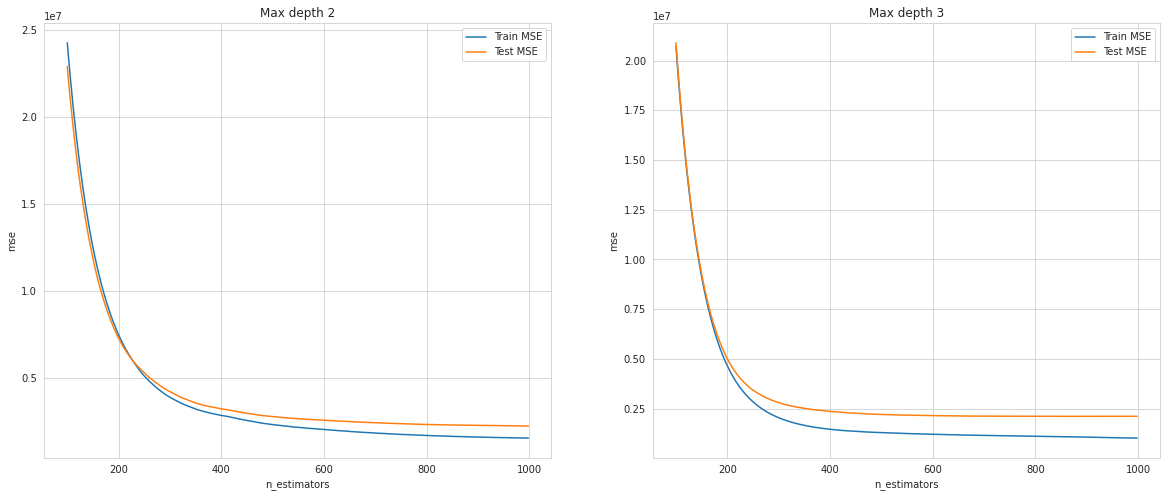

In [25]:
sns.set_style(style="whitegrid")
fig,(ax,ax_1)=plt.subplots(1,2,figsize=(20,8))

ax.set_title("Max depth 2")
ax.plot(first_evaluete["n_trees"],first_evaluete["mse_train"],label="Train MSE")
ax.plot(first_evaluete["n_trees"],first_evaluete["mse_test"],label="Test MSE")
ax.set_xlabel("n_estimators")
ax.set_ylabel("mse")
    
ax_1.set_title("Max depth 3")
ax_1.plot(second_evalue["n_trees"],second_evalue["mse_train"],label="Train MSE")
ax_1.plot(second_evalue["n_trees"],second_evalue["mse_test"],label="Test MSE")
ax_1.set_xlabel("n_estimators")
ax_1.set_ylabel("mse")
    

    
ax.legend()
ax_1.legend()


plt.show()

With a maximum depth of 2 there is less overfitting. The ideal number of estimators for this model ranges from **600** to **650**.

In [26]:
first_evaluete.query("n_trees>=610 and n_trees<=650")

,n_trees,mse_test,mse_train
255,610,2.573382e+06,2.035120e+06
256,612,2.569730e+06,2.030027e+06
257,614,2.567193e+06,2.027725e+06
258,616,2.563711e+06,2.020486e+06
259,618,2.562565e+06,2.017820e+06
260,620,2.558399e+06,2.012292e+06
261,622,2.555605e+06,2.009786e+06
262,624,2.550161e+06,2.004448e+06
263,626,2.547803e+06,1.999737e+06
264,628,2.545697e+06,1.996426e+06



Starting from the estimator number 630 there is no longer an improvement for the test data.

In [27]:
gbr=GradientBoostingRegressor(max_depth=2,
                          learning_rate=0.01,
                          n_estimators=630,
                          random_state=42)

In [42]:
gbr_pipeline=Pipeline([('preprocess',tf_colummns),
                       ('gbr',gbr)])

In [43]:
gbr_pipeline.fit(X_train,Y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['region', 'sex',
                                                   'smoker'])])),
                ('gbr',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=2,
                                           n_estimators=630,
                                           random_state=42))])

In [44]:
gbr_pipeline.score(X_train,Y_train) # evaluate with training data

0.9852488568613742

In [45]:
gbr_pipeline.score(X_test,Y_test) # evaluate with test data

0.9817020077116009

# *XGBOOST*

It is similar to adaboost. With the difference that xgboost can be used with GPU. Which training will be faster.

In [32]:
from xgboost import XGBRegressor

## *Selection number of estimators XGBOOST*

In [33]:
def evaluate(max_depth,lr):
    
    estimator_list=[]
    mse_train_list=[]
    mse_test_list=[]
    
    estimators=np.arange(100,1000,step=2)
    for estimator in estimators:
      
        model=XGBRegressor(max_depth=max_depth,n_estimators=estimator,learning_rate=lr,random_state=42,verbosity=0)
        model=Pipeline([("transform",tf_colummns),("model",model)])
        model.fit(X_train,Y_train)
        pred_train=model.predict(X_train)
        pred_test=model.predict(X_test)
        
        mse_train=mean_squared_error(Y_train,pred_train)
        mse_test=mean_squared_error(Y_test,pred_test)
        
        estimator_list.append(estimator)
        mse_test_list.append(mse_test)
        mse_train_list.append(mse_train)

        
    return estimator_list,mse_test_list,mse_train_list

In [34]:
first_evaluete=dataframe_evaluate_trees(max_depth=2,lr=0.01)

In [35]:
second_evaluete=dataframe_evaluate_trees(max_depth=3,lr=0.01)

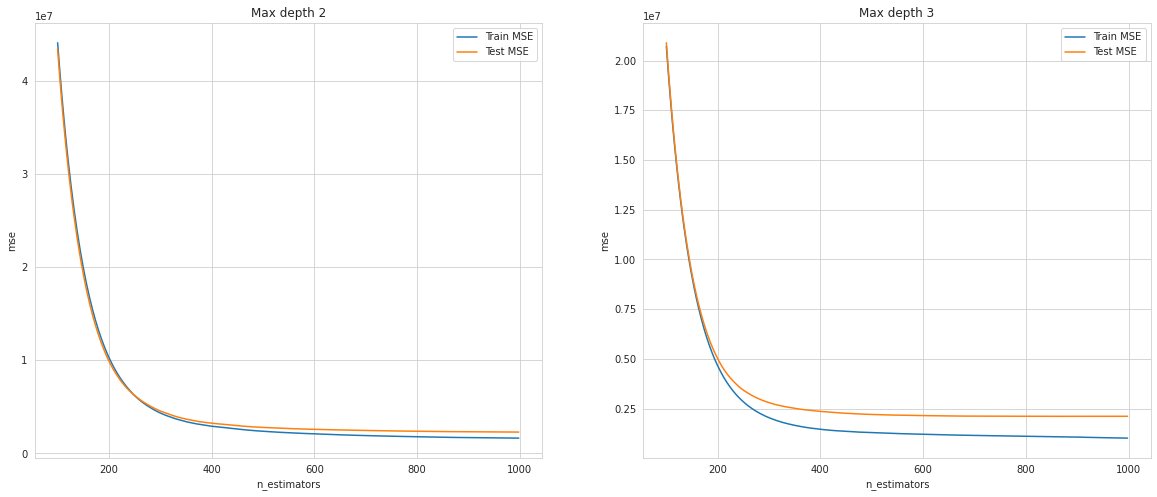

In [36]:
sns.set_style(style="whitegrid")
fig,(ax,ax_1)=plt.subplots(1,2,figsize=(20,8))

ax.set_title("Max depth 2")
ax.plot(first_evaluete["n_trees"],first_evaluete["mse_train"],label="Train MSE")
ax.plot(first_evaluete["n_trees"],first_evaluete["mse_test"],label="Test MSE")
ax.set_xlabel("n_estimators")
ax.set_ylabel("mse")
    
ax_1.set_title("Max depth 3")
ax_1.plot(second_evalue["n_trees"],second_evalue["mse_train"],label="Train MSE")
ax_1.plot(second_evalue["n_trees"],second_evalue["mse_test"],label="Test MSE")
ax_1.set_xlabel("n_estimators")
ax_1.set_ylabel("mse")
    

    
ax.legend()
ax_1.legend()


plt.show()


It happens in a similar way. With the difference that I can use more estimator without overfitting the model. The ideal range is between **600** to **650** estimators. Since from this amount, the error does not decrease drastically for the test data.

In [81]:
first_evaluete.query("n_trees>=600 and n_trees<=650")

,n_trees,mse_test,mse_train
250,600,2.583526e+06,2.098288e+06
251,602,2.580685e+06,2.095789e+06
252,604,2.579417e+06,2.091601e+06
253,606,2.575930e+06,2.086473e+06
254,608,2.573907e+06,2.083187e+06
255,610,2.568440e+06,2.077505e+06
256,612,2.566746e+06,2.071262e+06
257,614,2.565072e+06,2.068420e+06
258,616,2.562253e+06,2.065196e+06
259,618,2.558028e+06,2.059896e+06


We select 650. Since from ciho estimator there is no significant improvement.

In [46]:
xgb_reg=XGBRegressor(max_depth=2,
                     learning_rate=0.01,
                     n_estimators=650,
                     verbosity=0,
                     random_state=42)

xgb_pipeline=Pipeline([("transform",tf_colummns),("xgb",xgb_reg)])

In [47]:
xgb_pipeline.fit(X_train,Y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['region', 'sex',
                                                   'smoker'])])),
                ('xgb',
                 XGBRegressor(learning_rate=0.01, max_depth=2, n_estimators=650,
                              random_state=42, verbosity=0))])

In [48]:
xgb_pipeline.score(X_train,Y_train)

0.9851829733145766

In [49]:
xgb_pipeline.score(X_test,Y_test)

0.9818865587018973

In [59]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [73]:
class Evaluete():

  def __init__(self,model,X_data,y_true):

    self.X_data=X_data
    self.y_true=y_true

    self.model=model
    self.predict=self.model.predict(self.X_data)


  def mse(self):

    return mean_squared_error(self.y_true,self.predict)

  def r2(self):

    return r2_score(self.y_true,self.predict)

  def cv_score(self):
    
    return cross_val_score(self.model,self.X_data,self.y_true,cv=10).mean()
  

### **MSE**

Measures the average error between the original and predicted values.

In [65]:


mse_poly_train=Evaluete(lm,X_train_poly,Y_train).mse()
mse_poly_test=Evaluete(lm,X_test_poly,Y_test).mse()

mse_gbr_train=Evaluete(gbr_pipeline,X_train,Y_train).mse()
mse_gbr_test=Evaluete(gbr_pipeline,X_test,Y_test).mse()

mse_xgb_train=Evaluete(xgb_pipeline,X_train,Y_train).mse()
mse_xgb_test=Evaluete(xgb_pipeline,X_test,Y_test).mse()


## **$R²$**


It measures the degree of fit between the original value and the predictions. The closer it is to 1, the closer the original and predicted values ​​will be.

In [77]:

r2_poly_train=Evaluete(lm,X_train_poly,Y_train).r2()
r2_poly_test=Evaluete(lm,X_test_poly,Y_test).r2()

r2_gbr_train=Evaluete(gbr_pipeline,X_train,Y_train).r2()
r2_gbr_test=Evaluete(gbr_pipeline,X_test,Y_test).r2()

r2_xgb_train=Evaluete(xgb_pipeline,X_train,Y_train).r2()
r2_xgb_test=Evaluete(xgb_pipeline,X_test,Y_test).r2()

### **Cross Validation**

It measures the degree of generalization of the model. It divides the data into several subsets by the amount said by the user. To subsequently obtain the average value of generalization.

In [74]:
cv_poly=Evaluete(lm,X_test_poly,Y_test).cv_score()
cv_gbr=Evaluete(gbr_pipeline,X_test,Y_test).cv_score()
cv_xgb=Evaluete(xgb_pipeline,X_test,Y_test).cv_score()

### **Dataframe evaluation**

In [78]:
models_names=["Polynomial Regression","Gradient Boosting","XGBOOST"]

mse_train=[mse_poly_train,mse_gbr_train,mse_xgb_train]
mse_test=[mse_poly_test,mse_gbr_test,mse_xgb_test]

r2_train=[r2_poly_train,r2_gbr_train,r2_xgb_train]
r2_test=[r2_poly_test,r2_gbr_test,r2_xgb_test]

cv=[cv_poly,cv_gbr,cv_xgb]

evaluate_df=pd.DataFrame({"Model":models_names,
                          "MSE train":mse_train,
                          "MSE test":mse_test,
                          "R2 train":r2_train,
                          "R2 test":r2_test,
                          "CV":cv})

In [79]:
evaluate_df

,Model,MSE train,MSE test,R2 train,R2 test,CV
0,Polynomial Regression,4.936247e+06,6.461016e+06,0.963403,0.953449,0.950897
1,Gradient Boosting,1.989649e+06,2.539644e+06,0.985249,0.981702,0.978221
2,XGBOOST,1.998535e+06,2.514029e+06,0.985183,0.981887,0.979176


XGBOOST and gradient Boosting have very similar metrics to gradient boosting. But **XGBOOST** performs better for test data.

In [83]:


df_test=pd.DataFrame({"true_values":Y_test,
                        "pred_poly":pred_poly_test,
                      "pred_gbr":pred_gbr_test,
                      "pred_xgb":pred_xgb_test,
                      "smoker":X_test["smoker"]
                     })

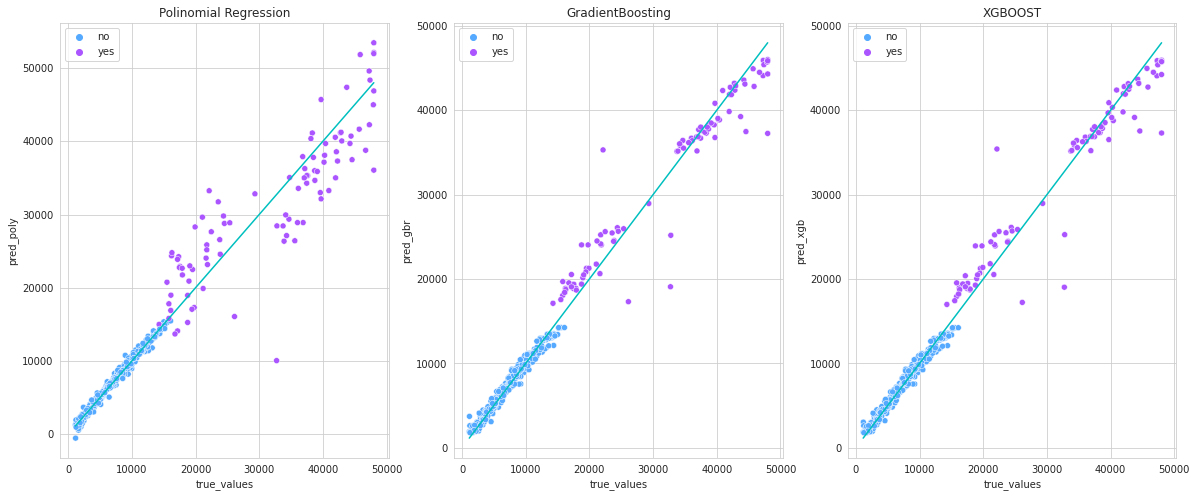

In [85]:
fig,(ax_0,ax_1,ax_2)=plt.subplots(1,3,figsize=(20,8))
sns.set_style(style="whitegrid")

ax_0.set_title("Polinomial Regression")
sns.scatterplot(data=df_test,x="true_values",y="pred_poly",color="red",hue="smoker",ax=ax_0,palette="cool")
sns.lineplot(data=df_test,x="true_values",y="true_values",color="c",ax=ax_0)


ax_1.set_title("GradientBoosting")
sns.scatterplot(data=df_test,x="true_values",y="pred_gbr",color="red",hue="smoker",ax=ax_1,palette="cool")
sns.lineplot(data=df_test,x="true_values",y="true_values",color="c",ax=ax_1)

ax_2.set_title("XGBOOST")
sns.scatterplot(data=df_test,x="true_values",y="pred_xgb",color="red",hue="smoker",ax=ax_2,palette="cool")
sns.lineplot(data=df_test,x="true_values",y="true_values",color="c",ax=ax_2)

plt.show()

## **Conclusion** 

* The **Polynomial Regression** is good to predict those users who do not smoke, for smokers it gives not so accurate predictions.

* **Gradient Boosting** It is good for both cases.

* **XGBOOST** Has a better root mean square error than using gradient boosting. In turn, it is faster to train and presents fewer symptoms of overfitting.